In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import time
print(torch.__version__)

1.3.0


In [2]:
def onehot(length, num):
    d = np.zeros(length)
    d[num] = 1
    return d

In [3]:
def dataread(data_dir):
    datt = []
    filenames = os.listdir(data_dir)
    file = [os.path.join(data_dir, f) for f in filenames if f.endswith('.jpg')]
    labels2 = [int(os.path.split(filename)[-1][0]) for filename in file]

    #print(len(file),len(labels2))
    for i in range(len(file)):
        datt.append([file[i],onehot(6,labels2[i])])
        #print(len([file[i],onehot(6,labels2[i])]))
    return datt

In [4]:
class SIGNSDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.filenames = os.listdir(data_dir)
        self.filenames = [os.path.join(data_dir, f) for f in self.filenames if f.endswith('.jpg')]

        #self.labels = [int(os.path.split(filename)[-1][0]) for filename in self.filenames]
        self.labels2 = [int(os.path.split(filename)[-1][0]) for filename in self.filenames]
        #print(self.labels2)
        self.labels = np.array([onehot(6,i) for i in self.labels2])
        #self.filenames = data_dir[:,0]
        #self.labels = data_dir[:,1]
        self.transform = transform

    def __len__(self):
        # return size of dataset
        return len(self.filenames)

    def __getitem__(self, idx):
        image = Image.open(self.filenames[idx])  # PIL image
        #image = Image.open(self.filenames[idx]).convert('LA')  # PIL image
        #image = ImageOps.equalize(image, mask = None)
        image = self.transform(image)
        return image,self.labels[idx]

In [5]:
imgsize = 64

In [6]:
train_transformer = transforms.Compose([
    transforms.Resize((imgsize,imgsize)),
    transforms.RandomHorizontalFlip(),  # randomly flip image horizontally
    transforms.ToTensor()  # transform it into a torch tensor
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
    ])

train_data_path = "SIGNS_dataset/train_signs/"
traindata = SIGNSDataset(train_data_path, train_transformer)

dl = DataLoader(traindata, batch_size=32, shuffle=True,
                                        num_workers=4,
                                        pin_memory=True)

In [7]:
print(traindata.labels[:1])
print(traindata.filenames[0:1])

[[0. 0. 0. 0. 0. 1.]]
['SIGNS_dataset/train_signs/5_IMG_5467.jpg']


In [8]:
test_transformer = transforms.Compose([
    transforms.Resize((imgsize,imgsize)),
    transforms.RandomHorizontalFlip(),  # randomly flip image horizontally
    transforms.ToTensor()  # transform it into a torch tensor
    ])

test_data_path = "SIGNS_dataset/test_signs/"
testdata = SIGNSDataset(test_data_path, test_transformer)

tl = DataLoader(testdata, batch_size=32, shuffle=False,
                                        num_workers=4,
                                        pin_memory=True)

In [9]:
# a = tl.dataset[1][0].numpy()
# print(a.shape)

# c = np.squeeze(a,axis=0)
# plt.imshow(c, cmap='gray')

0


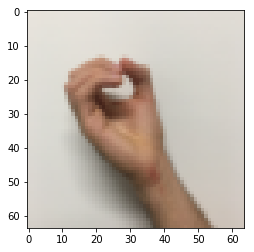

In [10]:
plt.imshow(transforms.ToPILImage()(tl.dataset[1][0]).convert('RGB'))

print(np.argmax(tl.dataset.labels[1]))


In [11]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        # Inspired by the implementation of binary_cross_entropy_with_logits
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})".format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + ((-max_val).exp() + (-input - max_val).exp()).log()

        # This formula gives us the log sigmoid of 1-p if y is 0 and of p if y is 1
        invprobs = F.logsigmoid(-input * (target * 2 - 1))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

In [12]:
model = models.mobilenet_v2()
model.classifier = nn.Sequential(
          #nn.Dropout(p=0.1, inplace=False),
          nn.Linear(in_features=1280, out_features=64, bias=True),
          #nn.Dropout(p=0.2, inplace=False),
          nn.Linear(in_features=64, out_features=6, bias=True))
model.cuda()

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [13]:
# model = models.resnet18(pretrained=False)
# #densenet_model.features.conv0 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# model.fc= nn.Linear(in_features=512, out_features=6, bias=True)
# model.cuda()

In [14]:
#optimizer = torch.optim.Adam(densenet_model.parameters(), lr=0.001)   # optimize all cnn parameters
optimizer = torch.optim.Adam(model.parameters(),lr=0.002)
loss_func = nn.CrossEntropyLoss() 
#loss_func = FocalLoss(0.4)

In [15]:
def train(epoch):
    model.train()
    for i, (train_batch, labels_batch) in enumerate(dl):
        labels_batch = np.argmax(labels_batch,axis=1)
        train_batch, labels_batch = Variable(train_batch).cuda(), Variable(labels_batch).cuda()

        # compute model output and loss
        output_batch = model(train_batch)
        loss = loss_func(output_batch, labels_batch.long())
        # clear previous gradients, compute gradients of all variables wrt loss
        optimizer.zero_grad()
        loss.backward()

        # performs updates using calculated gradients
        optimizer.step()
        torch.cuda.empty_cache()
        if i % 8 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, 
                    i * len(train_batch), len(dl.dataset),100. * i / len(dl), loss.data.item()))
    print("Finish")
    #GPUtil.showUtilization()

In [16]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in tl:
        target = np.argmax(target,axis=1)
        data, target = Variable(data).cuda(), Variable(target).cuda()
        with torch.no_grad():
            output = model(data)
            # sum up batch loss
            los = loss_func(output, target.long())
        #print(los)
        test_loss += los
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        #target = target.data.max(1, keepdim=True)[1]
        #print(output.shape)
        #print(pred.shape)
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        #print(format(correct))

    #print(test_loss)
    test_loss /= len(tl)
    torch.cuda.empty_cache()
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'
          .format(test_loss, correct, len(tl.dataset),
        100. * correct / len(tl.dataset)))
    
    
    #print(float(test_loss))
    global Loss
    global Accuracy
    #Loss = np.append(Loss,float(test_loss))
    #print(Loss)
    #Accuracy = np.append(Accuracy,float(100. * correct / len(tl.dataset)))

In [17]:
for epoch in range(30):
    if epoch == 1:
        ts = time.time()
    train(epoch)
    test()
te = time.time()
print("Total cost %f sec" % (te - ts))

Train Epoch: 0 [0/1080 (0%)]	Loss: 1.829743
Train Epoch: 0 [256/1080 (24%)]	Loss: 1.885530
Train Epoch: 0 [512/1080 (47%)]	Loss: 2.258322
Train Epoch: 0 [768/1080 (71%)]	Loss: 1.776201
Train Epoch: 0 [1024/1080 (94%)]	Loss: 1.317649
Finish

Test set: Average loss: 1.9012, Accuracy: 20/120 (16.67%)

Train Epoch: 1 [0/1080 (0%)]	Loss: 1.454731
Train Epoch: 1 [256/1080 (24%)]	Loss: 1.517343
Train Epoch: 1 [512/1080 (47%)]	Loss: 1.343399
Train Epoch: 1 [768/1080 (71%)]	Loss: 1.188999
Train Epoch: 1 [1024/1080 (94%)]	Loss: 0.877466
Finish

Test set: Average loss: 1.8281, Accuracy: 30/120 (25.00%)

Train Epoch: 2 [0/1080 (0%)]	Loss: 1.019857
Train Epoch: 2 [256/1080 (24%)]	Loss: 0.967401
Train Epoch: 2 [512/1080 (47%)]	Loss: 0.864498
Train Epoch: 2 [768/1080 (71%)]	Loss: 1.507184
Train Epoch: 2 [1024/1080 (94%)]	Loss: 0.995626
Finish

Test set: Average loss: 2.1138, Accuracy: 55/120 (45.83%)

Train Epoch: 3 [0/1080 (0%)]	Loss: 0.788400
Train Epoch: 3 [256/1080 (24%)]	Loss: 1.059112
Train Epo

Train Epoch: 27 [0/1080 (0%)]	Loss: 0.011071
Train Epoch: 27 [256/1080 (24%)]	Loss: 0.179492
Train Epoch: 27 [512/1080 (47%)]	Loss: 0.042268
Train Epoch: 27 [768/1080 (71%)]	Loss: 0.529019
Train Epoch: 27 [1024/1080 (94%)]	Loss: 0.137688
Finish

Test set: Average loss: 0.4088, Accuracy: 106/120 (88.33%)

Train Epoch: 28 [0/1080 (0%)]	Loss: 0.015151
Train Epoch: 28 [256/1080 (24%)]	Loss: 0.011483
Train Epoch: 28 [512/1080 (47%)]	Loss: 0.017530
Train Epoch: 28 [768/1080 (71%)]	Loss: 0.209916
Train Epoch: 28 [1024/1080 (94%)]	Loss: 0.105532
Finish

Test set: Average loss: 0.2917, Accuracy: 108/120 (90.00%)

Train Epoch: 29 [0/1080 (0%)]	Loss: 0.079701
Train Epoch: 29 [256/1080 (24%)]	Loss: 0.321745
Train Epoch: 29 [512/1080 (47%)]	Loss: 0.017544
Train Epoch: 29 [768/1080 (71%)]	Loss: 0.078436
Train Epoch: 29 [1024/1080 (94%)]	Loss: 0.006337
Finish

Test set: Average loss: 0.3918, Accuracy: 105/120 (87.50%)

Total cost 911.141121 sec


In [18]:
model = model.cpu()
torch.save(model, 'cnn_stanford.pkl')

/home/user1/pytorch_g/lib/python3.5/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MobileNetV2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/user1/pytorch_g/lib/python3.5/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/user1/pytorch_g/lib/python3.5/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ConvBNReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/user1/pytorch_g/lib/python3.5/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + 

In [19]:
#single image test
import matplotlib.pyplot as plt
single_transforms = transforms.Compose(
        [
        transforms.Resize((128,128)),
        transforms.ToTensor()
        ]
)
#model  = torch.load('cnn_stanford.pkl').cpu()

torch.Size([3, 128, 128])
torch.Size([1, 3, 128, 128])
(3, 128, 128)
(128, 128, 3)


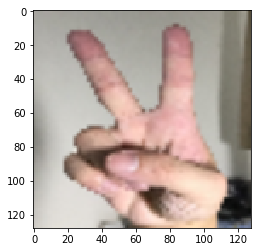

In [20]:
img = Image.open("te.jpg")
img = img.resize((imgsize,imgsize))
#img = img.rotate(-90)
#img = ImageOps.equalize(img, mask = None).convert('L')
image = single_transforms(img).cpu()
imgToShow = image.numpy()
print(image.shape)
image = image.unsqueeze(0)
print(image.shape)

print(imgToShow.shape)
imgToShow = imgToShow.transpose((1, 2, 0))
print(imgToShow.shape)
plt.imshow(imgToShow, cmap='gray')
plt.show()

In [21]:
single_out = model(image)
print(single_out)
p = torch.max(single_out, 1)[1].data.numpy().squeeze()
print(p)

tensor([[ 0.1086,  0.5150, -1.7937,  1.3823, -1.5183,  1.6468]],
       grad_fn=<AddmmBackward>)
5


In [22]:
model.cpu().eval()
example = torch.rand(1, 3, 128, 128)
traced_script_module = torch.jit.trace(model, example)
traced_script_module.save("assets/model.pt")